In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings; warnings.simplefilter('ignore')
import sys
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_halopull
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models
import seaborn as sns
from scipy import interpolate

In [3]:
plt.style.use('../paper/paper.mplstyle')
double_textwidth = 7.0 #inches
single_textwidth = 3.5 #inches

### calling in 10k merger tree realizations

### first the variance in the data

In [4]:
from scipy.stats import ks_2samp

def lnL_PNsat(data, model):
    lnL = np.sum(np.log(model.PNsat[data.Nsat_perhost]))
    if np.isinf(lnL):
        #print("index error in Pnsat")
        return -np.inf
    else:
        return lnL

def lnL_KS_max(data, model):
    try:
        clean_max_split = list(map(model.max_split.__getitem__, data.model_mask)) # this might yield an index error!
        p_vals = np.array(list(map(lambda x, y: ks_2samp(x, y)[1], data.clean_max_split, clean_max_split)))
        return np.sum(np.log(p_vals))
    except IndexError:
        #print("this model is not preferable!")
        return -np.inf

In [5]:
fid_theta = [10.5, 2.0, 0,0, 0.0, 0.0, 0.0]
teste = jsm_models.SAMPLE_SAGA_MODELS(fid_theta, meta_path="../../../data/MW-analog/meta_data_psi4/", extra_path="../../../data/MW-analog/meta_data_psi3/", SAGA_ind=0)

selecting the 0  SAGA sample
Grabbing the extra trees to make the model and collapsing to 2D!
converting the subhalos to satellites


# first the data

In [7]:
Mstat = jsm_stats.SatStats_M(lgMs_model, min_mass=6.5, max_N=500)

In [8]:
lnLs = []
step_size = 100  # Set the step size to 100
total_length = len(lgMs_data)  # Total length of the data

for i in range(0, total_length, step_size):
    saga_block = slice(i, i + step_size)  # Create a slice for the current block
    Dstat_i = jsm_stats.SatStats_D(lgMs_data[saga_block], min_mass=6.5, max_N=500)
    lnL_i = lnL_PNsat(Dstat_i, Mstat) + lnL_KS_max(Dstat_i, Mstat)
    lnLs.append(lnL_i)

lnLs  = np.array(lnLs)
lnLs_clean_D = lnLs[~np.isinf(lnLs)]
sigma_D = lnLs_clean_D.std(ddof=1)

# randint = np.random.choice(np.arange(0, 10000), size=(100,100), replace=False)
# lnLs = []
# for saga_block in randint:
#     Dstat_i = jsm_stats.SatStats_D(lgMs_data[saga_block], min_mass=6.5, max_N=500)
#     lnL_i = lnL_PNsat(Dstat_i, Mstat) + lnL_KS_max(Dstat_i, Mstat)
#     lnLs.append(lnL_i)

# lnLs  = np.array(lnLs)
# lnLs_clean_D = lnLs[~np.isinf(lnLs)]
# print(lnLs_clean_D.std(ddof=1))

# now for the model

In [21]:
lgMs_data = lgMs_data.reshape((100,100,lgMs_data.shape[1]))

lgMs_model = lgMs_model.reshape((100,100,lgMs_model.shape[1]))

In [27]:
lnL_mat = np.full((100,100), -np.inf)

for i, saga_block in enumerate(lgMs_data):
    Dstat_i = jsm_stats.SatStats_D(saga_block, min_mass=6.5, max_N=500)

    for j, model_block in enumerate(lgMs_data):
        Mstat_j = jsm_stats.SatStats_M(model_block, min_mass=6.5, max_N=500)
        lnL_ij = lnL_PNsat(Dstat_i, Mstat_j) + lnL_KS_max(Dstat_i, Mstat_j)

        lnL_mat[i,j] = lnL_ij

In [30]:
lnL_mat[np.isinf(lnL_mat)] = np.nan

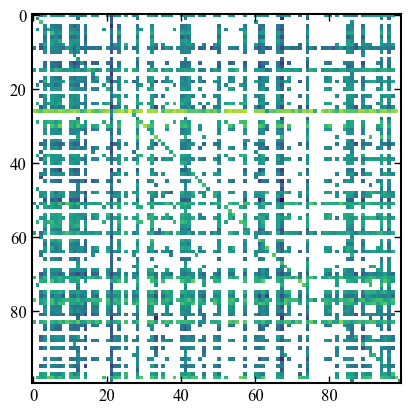

In [32]:
plt.imshow(lnL_mat)

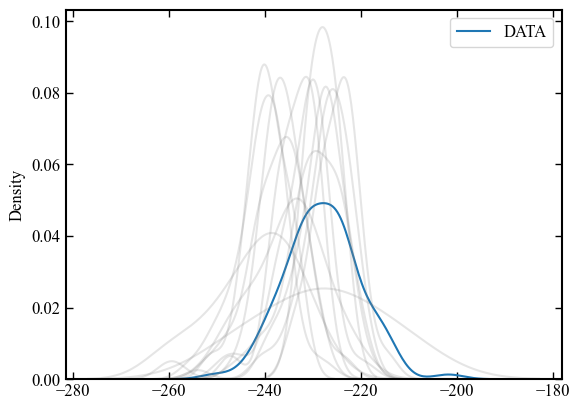

In [38]:
sns.kdeplot(lnLs_clean_D, label="DATA")
for row in lnL_mat[0:14]:
    sns.kdeplot(row, alpha=0.2, color="grey")
plt.legend()
plt.show()

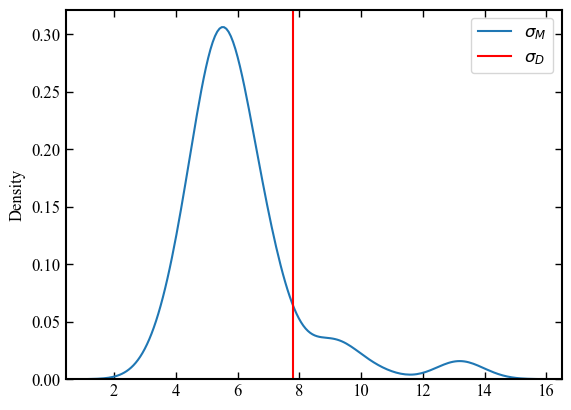

In [46]:
sns.kdeplot(np.nanstd(lnL_mat, ddof=1, axis=1), label="$\sigma_M$")
plt.axvline(np.nanstd(lnLs_clean_D, ddof=1), color="red", label="$\sigma_D$")
plt.legend()
plt.show()